WALDO RIVIER 07.12.2018 Exercices module 3 WARM-UP
---
Applied Data Science : Machine Learning
---

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import itertools

from scipy.linalg import lstsq
from scipy import stats

from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

working directory 

In [2]:
working_dir = os.getcwd()


Warm-UP - TASK 1
--

In [100]:
data_file = os.path.join(working_dir, 'Data', 'module_3', 'task-1.csv')

In [101]:
data_df = pd.read_csv(data_file)

In [102]:
x = data_df.iloc[:,0]
y = data_df.iloc[:,1]

variable change x -> _x = log(x)

In [103]:
_x = np.log(x)

Fit a linear regression  

In [104]:
coefs = np.polyfit(_x, y, deg = 1)
y_pred = np.polyval(coefs, _x)

Print the model 

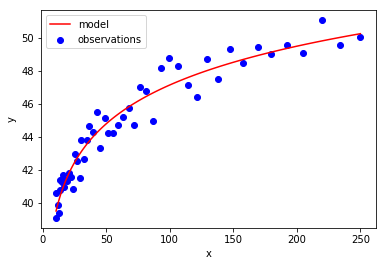

In [105]:
x_model = np.linspace(min(_x), max(_x), num=100)
y_model = np.polyval(coefs, x_model)

plt.scatter(x, y, label='observations', color='blue')
plt.plot(np.exp(x_model), y_model, label = 'model', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Metrics 

In [106]:
print('mse :', mse(y, y_pred))

mse : 0.6368530350551357


Compute baseline (default strategy = mean)

In [112]:
_X = np.c_[_x]
d_reg = DummyRegressor()
d_reg.fit(_X, y)
y_pred_bsl = d_reg.predict(_X)

print ('mse baseline:', mse(y, y_pred_bsl))

mse baseline: 10.822865744399998


Compares metrics with R2 scores 

(total error - model error) / total error => 1 - model error / total error


In [44]:
R2 = 1 - mse(y, y_pred) / mse(y, y_pred_bsl)

print ('R2 :', R2)

R2 : 0.9411567093138288


POLYFIT vs GRADIENT DESCENT
-- 

Polyfit : 
    - analytical solution (implement OLS resolution)
    - finds the best polynomial response (y) to problem with one feature (x)

 Gradient descent : 
    - general iterative algorithm 
    - apply to multi-features problems


Warm-UP - TASK 2
--

Give an idea of what we plot

In [81]:
def plot_df(data_df, target) :
    
    plt.scatter(data_df.x1, data_df[target], label = 'x1', color = 'red')
    plt.scatter(data_df.x2, data_df[target], label = 'x2',color = 'blue')
    plt.scatter(data_df.x3, data_df[target], label = 'x3',color = 'green')
    plt.legend()
    plt.show()

Evaluate model linear / huber loss
Stores metrics in a list (results)

In [89]:
def evaluate_model(reg_type, data_df, features, target, results):

    res = {}

    X = data_df[features].values
    y = data_df[target].values
    y = np.c_[y]

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, train_size=0.8, test_size=0.2, random_state=2)

    # linear regression without removing outliers

    if reg_type == 'linear':
        reg = LinearRegression()
    else:
        if reg_type == 'huber':
            reg = HuberRegressor(1.35)
            y_tr = y_tr.flatten()
    
    reg.fit(X_tr, y_tr)

    y_tr_pred = reg.predict(X_tr)
    y_te_pred = reg.predict(X_te)

    # metrics
    
    res['reg_type'] = reg_type
    res['mae_tr'] = mae(y_tr, y_tr_pred)
    res['mae_te'] = mae(y_te, y_te_pred)

    results.append(res)

In [90]:
data_file = os.path.join(working_dir, 'Data', 'module_3', 'task-2.csv')
data_df = pd.read_csv(data_file)

target = 'y'
features = data_df.columns.tolist()
features.remove(target)

Plot y in response of x1, x2, x3 before removing any outliers

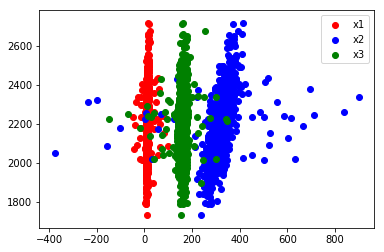

In [91]:
results = []
evaluate_model('linear', data_df, features, target, results)
evaluate_model('huber', data_df, features, target, results)
plot_df(data_df, target)

In [92]:
df_results = pd.DataFrame(results)
df_results

,mae_te,mae_tr,reg_type
0,119.156974,116.141412,linear
1,99.602949,106.155610,huber


Remove outliers (features and target)  with the criteria z > 2 

In [93]:
data_df_wo = data_df.copy()
for f in data_df.columns:
    z = (data_df_wo[f] - data_df_wo[f].mean()) / data_df_wo[f].std()
    outliers = np.abs(z) >= 2

    print (str(f) + ': number of outliers removed = ' + str(outliers.sum()))
    data_df_wo = data_df_wo[~outliers]

x1: number of outliers removed = 35
x2: number of outliers removed = 14
x3: number of outliers removed = 26
y: number of outliers removed = 40


Plot y in response of x1, x2, x3 after removing any outliers

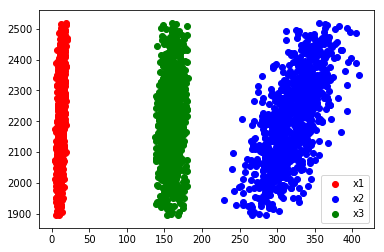

In [96]:
plot_df(data_df_wo, target)

In [97]:
results = []
evaluate_model('linear', data_df_wo, features, target, results)
evaluate_model('huber', data_df, features, target, results)

df_results = pd.DataFrame(results)
df_results

,mae_te,mae_tr,reg_type
0,55.496075,50.134746,linear
1,99.602949,106.155610,huber


REMARK : after removing outliers, mae score is reduced by a factor 2 for linear regression while huber regression stay unchanged 

Warm-UP - TASK 3
--

In [113]:
def evaluate_model_poly(degree, x, y, is_ridge, alpha_ridge, results, plot = False):
    reg = None

    poly = PolynomialFeatures(degree, include_bias=False)

    poly.fit(x)
    X = poly.fit_transform(x)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, train_size=0.8, test_size=0.2, random_state=1)

    if is_ridge :
        if alpha_ridge is None:
            reg = Ridge()
        else:
            reg = Ridge(alpha_ridge)
    else :
        reg = LinearRegression()

    reg.fit(X_tr, y_tr)
        
    y_tr_pred = reg.predict(X_tr)
    y_te_pred = reg.predict(X_te)

    # draw the model
    x_model = np.linspace(min(x), max(x), num=100)
    x_model = x_model[:, np.newaxis]

    X_model = poly.transform(x_model)
    y_model = reg.predict(X_model)
    
    row = {}
    row['is_ridge'] = is_ridge
    row['L2']       = np.sum(reg.coef_ ** 2)
    row['degree']   = degree
    row['alpha']    = alpha_ridge
    row['mse_tr']   = mse(y_tr_pred, y_tr)
    row['mse_te']   = mse(y_te_pred, y_te)
    row['score_tr'] = reg.score(X_tr, y_tr)
    row['score_te'] = reg.score(X_te, y_te)

    if plot:
        plt.plot(x_model, y_model, label='model : ' + str("ridge regression = ") + str(is_ridge) + "; degree = " + str(degree) )
        plt.scatter(X_tr[:, 0], y_tr, label='train set')
        plt.scatter(X_te[:, 0], y_te, label='test set')
              
    results.append(row)

In [114]:
data_file = os.path.join(working_dir, 'Data', 'module_3', 'task-3.csv')
data_df = pd.read_csv(data_file)

x_ = data_df['x'].values
y = data_df['y'].values

Regression using polynomial features 

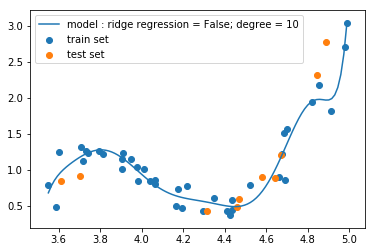

,L2,alpha,degree,is_ridge,mse_te,mse_tr,score_te,score_tr
0,2.392500e+15,None,10,False,0.093033,0.024904,0.832578,0.92728


In [115]:
x = x_[:, np.newaxis]

results = []
evaluate_model_poly(10, x, y, False, None, results, True)
plt.legend()
plt.show()

df_results = pd.DataFrame(results)
df_results


Regression using Ridge(alpha) / grid search

In [116]:
results = []
for degree in np.arange(10, 11):
    for alpha in np.logspace(-1, 10, num=100):
        evaluate_model_poly(degree, x, y, True, alpha, results, False)
      
df_results = pd.DataFrame(results)

Plot mse train / test

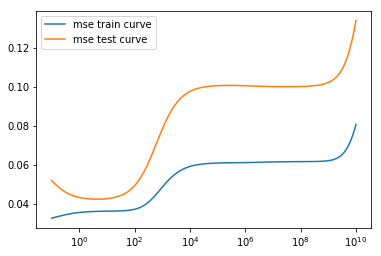

In [117]:
plt.semilogx(df_results.alpha, df_results.mse_tr, label='mse train curve')
plt.semilogx(df_results.alpha, df_results.mse_te, label='mse test curve')
plt.legend()
plt.show()

Determine the optimum

In [118]:
df_results
df_results.iloc[df_results.mse_te.idxmin(),]

L2          0.00306066
alpha          4.64159
degree              10
is_ridge          True
mse_te       0.0425099
mse_tr       0.0362375
score_te      0.923499
score_tr      0.894186
Name: 15, dtype: object

Draw the optimum ridge solution and compares with 
a polynomial regression of degree 4 

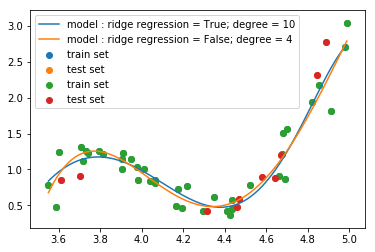

,L2,alpha,degree,is_ridge,mse_te,mse_tr,score_te,score_tr
0,3.060661e-03,4.64159,10,True,0.042510,0.036238,0.923499,0.894186
1,3.092000e+06,NaN,4,False,0.058123,0.031922,0.895401,0.906789


In [119]:
results = []
evaluate_model_poly(10, x, y, True, 4.64159, results, True)
evaluate_model_poly(4, x, y, False, None, results, True)

plt.legend()
plt.show()

df_results = pd.DataFrame(results)
df_results

REMARK : Both models perform equivalently, but Ridge regression with a lower L2